# Powertrain for UAV

In [187]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from scipy.integrate import quad, ode, odeint
from scipy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import gym
import json
from systems.powertrain import *
np.random.seed(43)

### The Continuous Battery Cell
Load profiles, parameters
- predefined curves must be derived emperically 

In [100]:
# only if curves need updated
# # load the battery curves
# battery_profiles = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')
# battery_profiles
# with open('params/battery_curves.json', 'w') as f:
#     json.dump(battery_profiles, f)

#### load battery params from json 

In [4]:
#with open('params/battery_params.json') as f:
#with open('params/tmp/battery1_0-0_3-8695.json') as f:
with open('params/battery1/14Dec20_13-00-50.json') as f:
    battery_params = json.load(f)
#battery_params

### create the battery cell

In [188]:
cbcell = ContinuousBatteryCell(**battery_params)

Using [ battery1 - 14Dec20_13-00-50] parameters


In [96]:
cbcell.period
ct = 1/3600*cbcell.period
dt = cbcell.nsteps(ct)

c = 3.8695

In [111]:
#cbcell.cycle_flag = True
obs, reward, done, info = cbcell.step(dt, c)
    #print(cbcell.age, cbcell.avg_load, cbcell.cycle_time, cbcell.z)
    
print(done)
print(cbcell.age, cbcell.z)

58.04250000000001
False
0.0 0.9958338501266075


In [126]:
cbcell.period = .05

In [212]:
cbcell.save_state()

### plot the battery profile curves
- q degradation
- r0 degradation
- soc ocv curve

4.052408561253653
0.013503516031979206
3.865514026190776


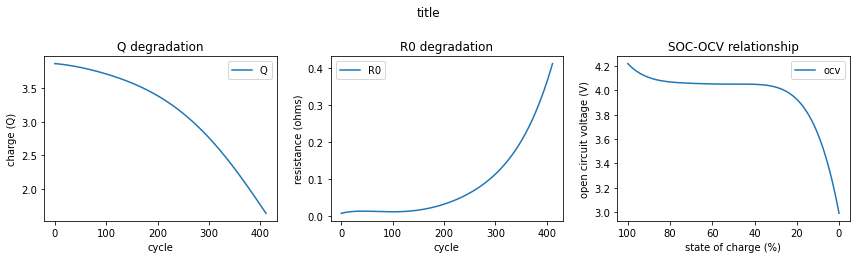

In [23]:
# shows that profile curves are continuous
print(cbcell.get_v(z=45.32434))
print(cbcell.get_r0(age=123.232))
print(cbcell.get_q(age=.973))

plot_q = np.array([np.arange(0, cbcell.eol), np.polyval(cbcell.q_coef, np.arange(0, cbcell.eol))])
plot_r = np.array([np.arange(0, cbcell.eol), np.polyval(cbcell.r0_coef, np.arange(0, cbcell.eol))])
plot_z = np.array([np.arange(0, 101), np.polyval(cbcell.z_coef, np.arange(0, 101))])

three_plot(plot1=plot_q, plot2=plot_r, plot3=plot_z, 
           label1=["Q"], label2=["R0"], label3=["ocv"], 
           title1="Q degradation", title2="R0 degradation", title3="SOC-OCV relationship",
           axes1=["cycle", "charge (Q)"], axes2=["cycle", "resistance (ohms)"], axes3=["state of charge (%)", "open circuit voltage (V)"],
           invert=[0,0,1], save=True, filename="figures/battery_profile_curves.png")

### EOD simulation

3.7695379166670047
run: 0	Q: 3.865	R0: 0.011	avg_load: 3.870	cycle_time: 3506	age: 2.700	eol: 412


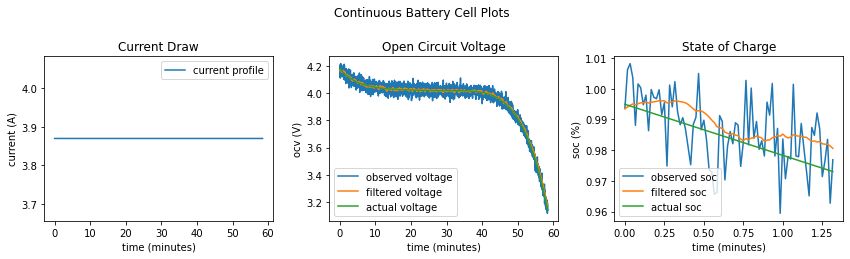

In [197]:
# simulate until EOD
#cbcell.Q = 4.2
cycle_test(cell=cbcell, dt=1.0, random_load=False, verbose=1,show_plot=True, reset=False, action=1)#, save_plot=True, file_name="figures/continuous_cell_test2.png")


### Charging simulation

3.7695379166670047
run: 0	Q: 3.865	R0: 0.011	avg_load: 3.870	cycle_time: 3506	age: 1.872	eol: 412


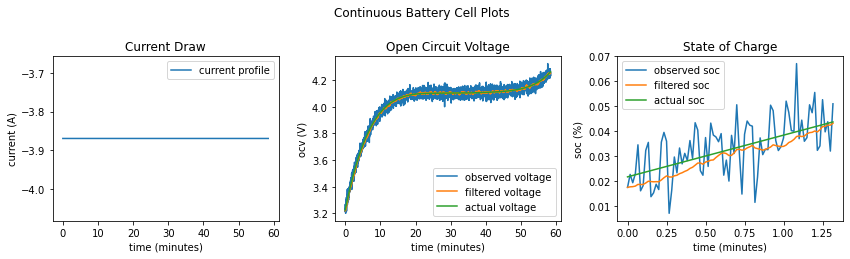

In [196]:
cycle_test(cell=cbcell, random_load=False, verbose=1, show_plot=True, reset=False, action=0)#, save_plot=True, file_name="figures/continuous_cell_charging.png")


### EOL simulation

Using [ battery1 - 14Dec20_13-00-50] parameters
3.788814671944713
run: 1	Q: 3.865	R0: 0.011	avg_load: 3.723	cycle_time: 3663	age: 0.762	eol: 412
3.770612777778116
run: 0	Q: 3.866	R0: 0.011	avg_load: 3.870	cycle_time: 3507	age: 0.873	eol: 412
3.7650332692230903
run: 2	Q: 3.866	R0: 0.011	avg_load: 4.927	cycle_time: 2750	age: 2.216	eol: 412
3.764163611111448
run: 0	Q: 3.865	R0: 0.011	avg_load: 3.870	cycle_time: 3501	age: 2.327	eol: 412
3.7717020058844732
run: 3	Q: 3.865	R0: 0.011	avg_load: 3.288	cycle_time: 4129	age: 2.924	eol: 412
3.7716876388892273
run: 0	Q: 3.864	R0: 0.011	avg_load: 3.870	cycle_time: 3508	age: 3.034	eol: 412
3.771315863331052
run: 4	Q: 3.864	R0: 0.011	avg_load: 3.446	cycle_time: 3939	age: 3.690	eol: 412
3.770612777778116
run: 0	Q: 3.864	R0: 0.011	avg_load: 3.870	cycle_time: 3507	age: 3.801	eol: 412
3.766874726025841
run: 5	Q: 3.864	R0: 0.011	avg_load: 4.069	cycle_time: 3332	age: 4.717	eol: 412
3.7663133333336707
run: 0	Q: 3.863	R0: 0.011	avg_load: 3.870	cycle_time: 350

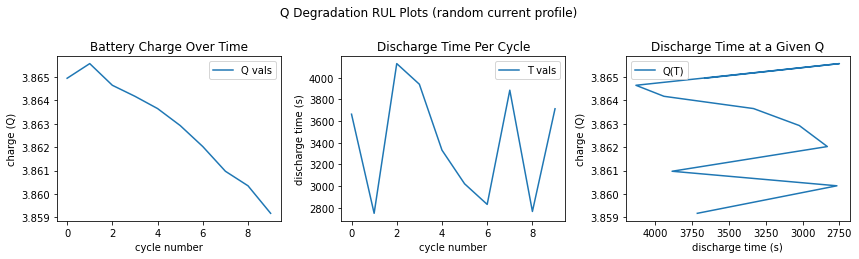

In [198]:
# create the cell
# with open('params/battery_params.json') as f:
#     battery_params = json.load(f)
cbcell = ContinuousBatteryCell(**battery_params)

# define some data containers
q_vals = []
t_vals = []
run_num = 1

# simulate until EOL
while(cbcell.age < 10):#.9*cbcell.eol):
    # discharge
    cycle_test(cell=cbcell, random_load=True, reset=False,verbose=1, dt=1.0, run_num=run_num, q_vals=q_vals, t_vals=t_vals)
    # charge
    cycle_test(cell=cbcell, random_load=False, verbose=1, show_plot=False, reset=False, action=0)
    run_num += 1

    # plot the results
three_plot(title="Q Degradation RUL Plots (random current profile)", figsize=(12,4), 
           plot1=np.array([np.arange(0, len(q_vals)), np.array(q_vals)]),
           plot2=np.array([np.arange(0, len(t_vals)), np.array(t_vals)]), 
           plot3=np.array([np.array(t_vals), np.array(q_vals)]),
           label1=["Q vals"],
           label2=["T vals"],
           label3=["Q(T)"],
           title1="Battery Charge Over Time",
           title2="Discharge Time Per Cycle",
           title3="Discharge Time at a Given Q",
           axes1=['cycle number', 'charge (Q)'],
           axes2=['cycle number', 'discharge time (s)'],
           axes3=['discharge time (s)', 'charge (Q)'],
           invert = [0,0,1],
           save=False,
           filename="figures/rul_plots_random_load.png")

In [18]:
t_vals[1]

3506